# Train, tune, and deploy a custom ML model using the Time Series Anomaly Detection (LSTM-AD) Algorithm from AWS Marketplace

The [Time Series Anomaly Detection (LSTM-AD) Algorithm from AWS Marketplace](https://aws.amazon.com/marketplace/pp/prodview-4pbvedtnnlphw) performs time series anomaly detection with the Long Short-Term Memory Network for Anomaly Detection (LSTM-AD). It implements both training and inference from CSV data and supports both CPU and GPU instances. The training and inference Docker images were built by extending the PyTorch 2.0 Python 3.10 SageMaker containers. 

#### Model Overview  
The LSTM-AD model predicts the time series with a multivariate stacked LSTM model.
The model parameters are learned on a training set containing only normal data (i.e. without anomalies) by minimizing the Mean Squared Error (MSE) between the actual and predicted values of the time series.
After the model has been trained, a multivariate Gaussian distribution is fitted to the model's prediction errors on an independent validation set (also without anomalies) using Maximum Likelihood Estimation (MLE).
At inference time, the model predicts the values of all the time series (which can now include anomalies) at each time step, and calculates the likelihood of the model's prediction errors under the fitted multivariate Gaussian distribution.
The computed Gaussian likelihood is then used as a normality score: the lower the Gaussian likelihood at a given a time step, the more likely the time step is to be an anomaly.

<img src=https://fg-research-assets.s3.eu-west-1.amazonaws.com/lstm-ad-diagram.png style="width:80%;margin-top:60px;margin-bottom:50px"/>

*LSTM-AD architecture (source: [ISBN 978-287587014-8](https://www.esann.org/sites/default/files/proceedings/legacy/es2015-56.pdf))*

**Notes:**
- The algorithm splits the training data into two independent subsets: one subset is used for training the LSTM model, while the other subset is used for calculating the prediction errors to which the parameters of the multivariate Gaussian distribution are fitted. The (optional) validation data accepted by the algorithm is only used for scoring the model, i.e. for calculating the MSE between the actual values of the time series in the validation dataset and their predicted values generated by the previously trained LSTM model.


- The algorithm views the multivariate time series as different measurements on the same system. An anomaly is intended as an abnormal behavior of the entire system, not of a single individual measurement. As a result, the algorithm outputs only one normality score for each time step, representing the likelihood that the overall system is in a normal state at that time step. The algorithm can also be applied to a univariate time series (i.e. to a single time series). Consider fitting the algorithm to each individual time series if the time series are not similar to each other and are not related, or if you need to identify the anomalies separately in each time series.  


- The algorithm predicts the time series sequence by sequence. Each sequence is used as input for predicting the next sequence. The algorithm uses non-overlapping sequences, whose length can be defined through the `sequence-length` hyperparameter. The sequence length (also referred to as window size or number of time steps) should be chosen such that enough sequences are available for training. For instance, if the length of the time series is 10000, consider choosing a sequence length not greater than 100. The algorithm does not return any output for the first sequence, as there is no previous sequence to use as input.

#### Model Resources 
- **Paper:** [Long Short Term Memory Networks for Anomaly Detection in Time Series](https://www.esann.org/sites/default/files/proceedings/legacy/es2015-56.pdf).

This sample notebook shows you how to train a custom ML model using the [Time Series Anomaly Detection (LSTM-AD) Algorithm from AWS Marketplace](https://aws.amazon.com/marketplace/pp/prodview-4pbvedtnnlphw).

**Note: This is a reference notebook and it cannot run unless you make the changes suggested in the notebook.**

## Pre-requisites
1. This notebook contains elements which render correctly in Jupyter interface. Open this notebook from an Amazon SageMaker Notebook Instance or Amazon SageMaker Studio.
1. Ensure that IAM role used has **AmazonSageMakerFullAccess**
1. Some hands-on experience using [Amazon SageMaker](https://aws.amazon.com/sagemaker/).
1. To use this algorithm successfully, ensure that:
    1. Either your IAM role has these three permissions and you have authority to make AWS Marketplace subscriptions in the AWS account used: 
        1. **aws-marketplace:ViewSubscriptions**
        1. **aws-marketplace:Unsubscribe**
        1. **aws-marketplace:Subscribe**  
    2. or your AWS account has a subscription to the [Time Series Anomaly Detection (LSTM-AD) Algorithm from AWS Marketplace](https://aws.amazon.com/marketplace/pp/prodview-4pbvedtnnlphw).

## Contents
1. [Subscribe to the algorithm](#1.-Subscribe-to-the-algorithm)
1. [Prepare dataset](#2.-Prepare-dataset)
	1. [Dataset format expected by the algorithm](#A.-Dataset-format-expected-by-the-algorithm)
	1. [Configure and visualize train and test dataset](#B.-Configure-and-visualize-train-and-test-dataset)
	1. [Upload datasets to Amazon S3](#C.-Upload-datasets-to-Amazon-S3)
1. [Train a machine learning model](#3:-Train-a-machine-learning-model)
	1. [Set up environment](#3.1-Set-up-environment)
	1. [Train a model](#3.2-Train-a-model)
1. [Deploy model and verify results](#4:-Deploy-model-and-verify-results)
    1. [Deploy trained model](#A.-Deploy-trained-model)
    1. [Create input payload](#B.-Create-input-payload)
    1. [Perform real-time inference](#C.-Perform-real-time-inference)
    1. [Visualize output](#D.-Visualize-output)
    1. [Calculate relevant metrics](#E.-Calculate-relevant-metrics)
    1. [Delete the endpoint](#F.-Delete-the-endpoint)
1. [Tune your model! (optional)](#5:-Tune-your-model!-(optional))
	1. [Tuning Guidelines](#A.-Tuning-Guidelines)
	1. [Define Tuning configuration](#B.-Define-Tuning-configuration)
	1. [Run a model tuning job](#C.-Run-a-model-tuning-job)
1. [Perform Batch inference](#6.-Perform-Batch-inference)
1. [Clean-up](#7.-Clean-up)
	1. [Delete the model](#A.-Delete-the-model)
	1. [Unsubscribe to the listing (optional)](#B.-Unsubscribe-to-the-listing-(optional))


## Usage instructions
You can run this notebook one cell at a time (by using Shift+Enter for running a cell).

## 1. Subscribe to the algorithm

To subscribe to the algorithm:
1. Open the algorithm listing page.
1. On the AWS Marketplace listing, click on the **Continue to subscribe** button.
1. On the **Subscribe to this software** page, review and click on **"Accept Offer"** if you agree with EULA, pricing, and support terms. 
1. Once you click on the **Continue to configuration** button and then choose a **region**, you will see a **Product ARN**. This is the algorithm ARN that you need to specify while training a custom ML model. **Copy the ARN corresponding to your region and specify the same in the following cell.**

In [1]:
algo_arn = "arn:aws:sagemaker:eu-west-1:661670223746:algorithm/lstm-ad-algo-v1-6"

## 2. Prepare dataset

In [2]:
import io
import datetime
import boto3
import sagemaker
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# S3 bucket
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
bucket

'sagemaker-eu-west-1-661670223746'

In [4]:
# EC2 instance
instance_type = "ml.m5.2xlarge"

### A. Dataset format expected by the algorithm

The training and validation datasets should be provided as CSV files. 
Each column of the CSV file represents a time series, while each row represents a time step.
All the time series should have the same length and should not contain missing values.
The CSV file should not contain any index column or column headers. 

You can find more information about dataset format in the **Usage Information** section of the algorithm listing page.

### B. Configure and visualize train and test dataset

The sample data provided in the algorithm's [GitHub repository](https://github.com/fg-research/lstm-ad-sagemaker) consists of two artificially generated time series. The training dataset contains 100000 samples, while the validation and test datasets contain 12500 samples. 

**Training dataset:**

In [5]:
training_dataset = pd.read_csv(
    "https://raw.githubusercontent.com/fg-research/lstm-ad-sagemaker/master/data/training/train.csv",
    header=None,
    index_col=None
)

In [6]:
training_dataset.shape

(100000, 2)

In [7]:
training_dataset.head()

,0,1
0,-10.636049,-7.004351
1,-8.454822,-11.163021
2,-9.284293,-7.023463
3,-12.651709,-10.763874
4,-6.937113,-11.395461


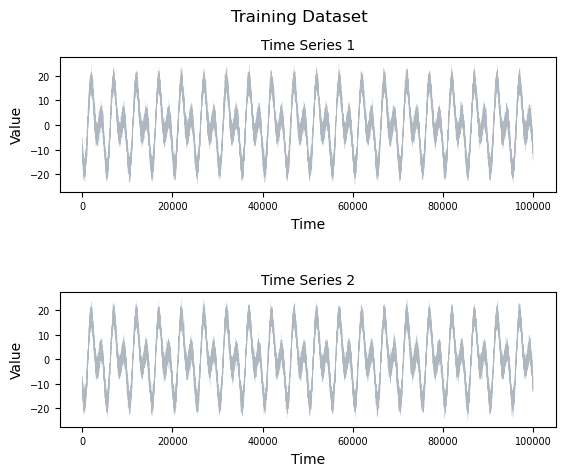

In [8]:
fig, axs = plt.subplots(nrows=training_dataset.shape[1], ncols=1, sharex=True)
for i in range(training_dataset.shape[1]):
    axs[i].plot(training_dataset.iloc[:, i], color="#AFB8C1", lw=0.1)
    axs[i].set_title(f"Time Series {i + 1}", size=10)
    axs[i].set(xlabel="Time", ylabel="Value")
    axs[i].xaxis.set_tick_params(labelbottom=True)
    axs[i].tick_params(axis="both", which="major", labelsize=7)
    axs[i].tick_params(axis="both", which="minor", labelsize=7)
fig.subplots_adjust(hspace=0.75)
fig.suptitle("Training Dataset")
fig.show()

**Validation dataset:**

In [9]:
validation_dataset = pd.read_csv(
    "https://raw.githubusercontent.com/fg-research/lstm-ad-sagemaker/master/data/training/valid.csv",
    header=None,
    index_col=None
)

In [10]:
validation_dataset.shape

(12500, 2)

In [11]:
validation_dataset.head()

,0,1
0,-10.137886,-10.991226
1,-9.030111,-12.478243
2,-8.637631,-11.949125
3,-10.196890,-9.419724
4,-7.966472,-11.655382


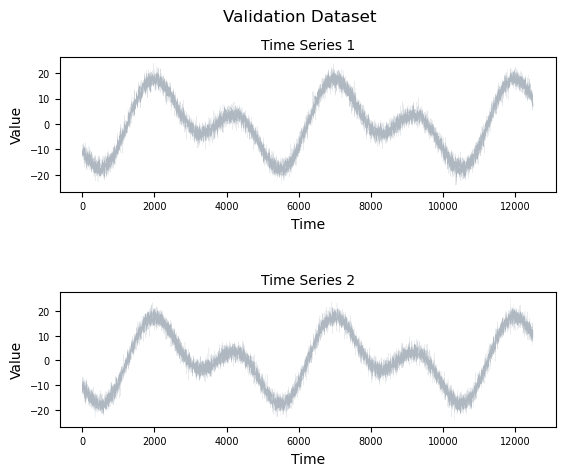

In [12]:
fig, axs = plt.subplots(nrows=validation_dataset.shape[1], ncols=1, sharex=True)
for i in range(validation_dataset.shape[1]):
    axs[i].plot(validation_dataset.iloc[:, i], color="#AFB8C1", lw=0.1)
    axs[i].set_title(f"Time Series {i + 1}", size=10)
    axs[i].set(xlabel="Time", ylabel="Value")
    axs[i].xaxis.set_tick_params(labelbottom=True)
    axs[i].tick_params(axis="both", which="major", labelsize=7)
    axs[i].tick_params(axis="both", which="minor", labelsize=7)
fig.subplots_adjust(hspace=0.75)
fig.suptitle("Validation Dataset")
fig.show()

### C. Upload datasets to Amazon S3

In [13]:
training_data = sagemaker_session.upload_string_as_file_body(
    body=training_dataset.to_csv(index=False, header=False),
    bucket=bucket,
    key="data/training/train.csv"
)

In [14]:
training_data

's3://sagemaker-eu-west-1-661670223746/data/training/train.csv'

In [15]:
validation_data = sagemaker_session.upload_string_as_file_body(
    body=validation_dataset.to_csv(index=False, header=False),
    bucket=bucket,
    key="data/training/valid.csv"
)

In [16]:
validation_data

's3://sagemaker-eu-west-1-661670223746/data/training/valid.csv'

## 3: Train a machine learning model

Now that dataset is available in an accessible Amazon S3 bucket, we are ready to train a machine learning model. 

### 3.1 Set up environment

In [17]:
role = sagemaker.get_execution_role()

### 3.2 Train a model

You can find more information about the model's hyperparameters in the **Hyperparameters** section of the algorithm listing page.

In [18]:
# define hyperparameters
hyperparameters = {
    "sequence-length": 100,
    "hidden-size": 128,
    "num-layers": 2,
    "dropout": 0.1,
    "lr": 0.001,
    "batch-size": 32,
    "epochs": 50,
}

For information on creating an `Estimator` object, see the [documentation](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html).

In [19]:
# create an estimator object for running a training job
estimator = sagemaker.algorithm.AlgorithmEstimator(
    algorithm_arn=algo_arn,
    base_job_name="lstm-ad-training",
    role=role,
    instance_count=1,
    instance_type=instance_type,
    input_mode="File",
    sagemaker_session=sagemaker_session,
    hyperparameters=hyperparameters,
)

In [20]:
# run the training job
estimator.fit({"training": training_data, "validation": validation_data})

INFO:sagemaker:Creating training-job with name: lstm-ad-training-2023-09-09-18-52-47-910


2023-09-09 18:52:48 Starting - Starting the training job...
2023-09-09 18:53:02 Starting - Preparing the instances for training......
2023-09-09 18:53:55 Downloading - Downloading input data...
2023-09-09 18:54:25 Training - Downloading the training image..................
2023-09-09 18:57:31 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-09-09 18:57:56,285 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-09-09 18:57:56,286 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-09-09 18:57:56,287 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-09-09 18:57:56,295 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-09-09 18:57:56,297 sagemaker_pytorch_container.training INFO     Invokin

See this [blog-post](https://aws.amazon.com/blogs/machine-learning/easily-monitor-and-visualize-metrics-while-training-models-on-amazon-sagemaker/) for more information how to visualize metrics during the process. You can also open the training job from [Amazon SageMaker console](https://console.aws.amazon.com/sagemaker/home?#/jobs/) and monitor the metrics/logs in **Monitor** section.

## 4: Deploy model and verify results

Now you can deploy the model for performing real-time inference.

### A. Deploy trained model

In [21]:
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type=instance_type,
    serializer=sagemaker.serializers.CSVSerializer(content_type="text/csv"),
    model_name=f"lstm-ad-model-{datetime.datetime.now().strftime(format='%Y-%m-%d-%H-%M-%S-%f')}",
    endpoint_name=f"lstm-ad-endpoint-{datetime.datetime.now().strftime(format='%Y-%m-%d-%H-%M-%S-%f')}",
)

INFO:sagemaker:Creating model package with name: lstm-ad-model-2023-09-09-18-59-32-619321


.........

INFO:sagemaker:Creating model with name: lstm-ad-model-2023-09-09-18-59-32-619321


INFO:sagemaker:Creating endpoint-config with name lstm-ad-endpoint-2023-09-09-18-59-32-619351
INFO:sagemaker:Creating endpoint with name lstm-ad-endpoint-2023-09-09-18-59-32-619351


------------!

Once the endpoint is in service, you can perform real-time inference.

### B. Create input payload

The inference algorithm takes as input a CSV file containing the time series.
Each column of the CSV file represents a time series, while each row represents a time step.
The CSV file should not contain any index column or column headers.
All the time series should have the same length and should not contain missing values.

**Test dataset:**

In [22]:
test_dataset = pd.read_csv(
    "https://raw.githubusercontent.com/fg-research/lstm-ad-sagemaker/master/data/inference/input/test.csv",
    header=None,
    index_col=None
)

In [23]:
test_dataset.shape

(12500, 2)

In [24]:
test_dataset.head()

,0,1
0,11.362138,11.850760
1,10.889519,10.856927
2,11.019723,11.645616
3,9.626194,11.602630
4,10.066778,11.032155


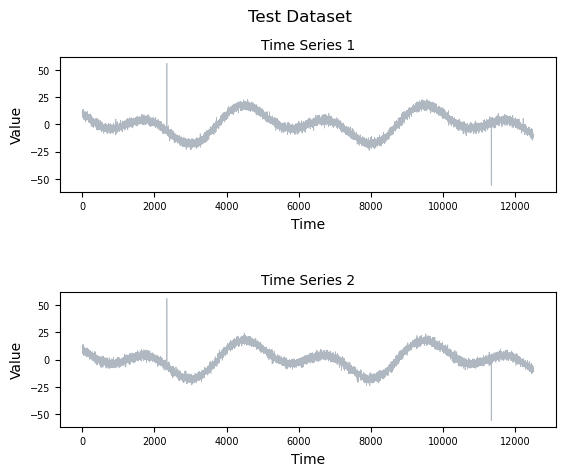

In [25]:
fig, axs = plt.subplots(nrows=test_dataset.shape[1], ncols=1, sharex=True)
for i in range(test_dataset.shape[1]):
    axs[i].plot(test_dataset.iloc[:, i], color="#AFB8C1", lw=0.5)
    axs[i].set_title(f"Time Series {i + 1}", size=10)
    axs[i].set(xlabel="Time", ylabel="Value")
    axs[i].xaxis.set_tick_params(labelbottom=True)
    axs[i].tick_params(axis="both", which="major", labelsize=7)
    axs[i].tick_params(axis="both", which="minor", labelsize=7)
fig.subplots_adjust(hspace=0.75)
fig.suptitle("Test Dataset")
fig.show()

In [26]:
test_data = sagemaker_session.upload_string_as_file_body(
    body=test_dataset.to_csv(index=False, header=False),
    bucket=bucket,
    key="data/inference/input/test.csv"
)

In [27]:
test_data

's3://sagemaker-eu-west-1-661670223746/data/inference/input/test.csv'

In [28]:
payload = sagemaker_session.read_s3_file(
    bucket=bucket,
    key_prefix="data/inference/input/test.csv"
)

### C. Perform real-time inference

In [29]:
response = sagemaker_session.sagemaker_runtime_client.invoke_endpoint(
    EndpointName=predictor.endpoint_name,
    ContentType="text/csv",
    Body=payload
)

real_time_predictions = response["Body"].read().decode("utf-8").split("\n")[:-1]
real_time_predictions = pd.DataFrame([x.split(",") for x in real_time_predictions]).replace("", np.nan).astype(float)

In [30]:
response

{'ResponseMetadata': {'RequestId': '0cd5ff37-d362-40a5-bc84-a460914283c2',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '0cd5ff37-d362-40a5-bc84-a460914283c2',
   'x-amzn-invoked-production-variant': 'AllTraffic',
   'date': 'Sat, 09 Sep 2023 19:06:52 GMT',
   'content-type': 'application/json',
   'content-length': '715537',
   'connection': 'keep-alive'},
  'RetryAttempts': 0},
 'ContentType': 'application/json',
 'InvokedProductionVariant': 'AllTraffic',
 'Body': <botocore.response.StreamingBody at 0x7f2fb7c95bd0>}

In [31]:
real_time_results = sagemaker_session.upload_string_as_file_body(
    body=real_time_predictions.to_csv(index=False, header=False),
    bucket=bucket,
    key="data/inference/output/real-time/real_time_predictions.csv"
)

In [32]:
real_time_results

's3://sagemaker-eu-west-1-661670223746/data/inference/output/real-time/real_time_predictions.csv'

### D. Visualize output

The inference algorithm outputs the normality scores and the predicted values of the time series. 
The normality scores are included in the first column, while the predicted values of the time series are included in the subsequent columns. 

**Note:** The LSTM-AD model predicts the time series sequence by sequence. The first sequence (e.g. the first 100 data points if the `sequence-length` hyperparameter is set equal to 100) is used as input to predict the second sequence (e.g. the data points from 101 to 200). Given that the first sequence has no previous sequence, the normality scores and predictions of the first sequence (e.g. of the first 100 data points) are not available.

In [33]:
real_time_predictions.shape

(12500, 3)

In [34]:
real_time_predictions.head()

,0,1,2
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN


In [35]:
real_time_predictions.tail()

,0,1,2
12495,-3.638773,-7.340789,-7.756263
12496,-2.908987,-7.303888,-7.327583
12497,-4.385940,-7.406969,-7.499327
12498,-4.583617,-7.409316,-7.668816
12499,-2.815022,-7.670213,-7.558024


In [36]:
real_time_predictions.isna().sum(axis=0)

0    100
1    100
2    100
dtype: int64

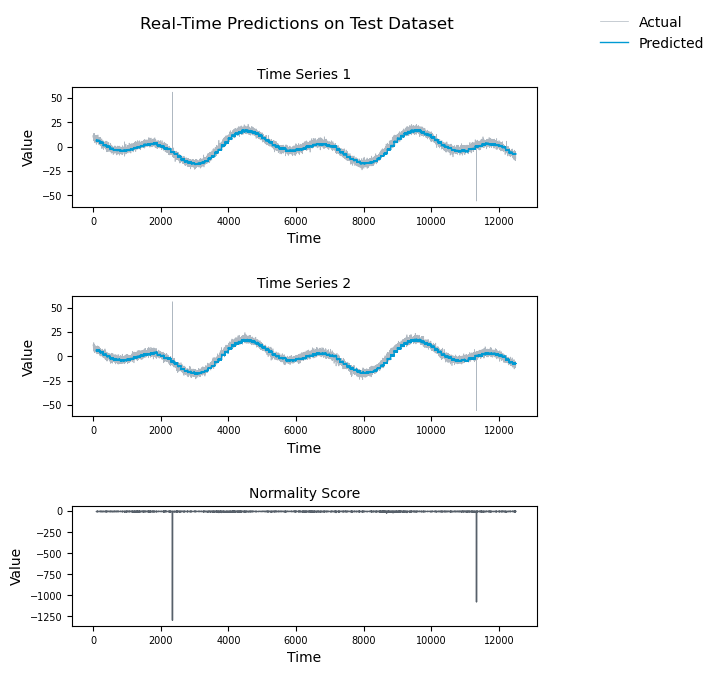

In [37]:
fig, axs = plt.subplots(nrows=test_dataset.shape[1] + 1, ncols=1, sharex=True, figsize=(6, 7))
for i in range(test_dataset.shape[1]):
    axs[i].plot(test_dataset.iloc[:, i], color="#AFB8C1", lw=0.5, label="Actual" if i == 0 else None)
    axs[i].plot(real_time_predictions.iloc[:, i + 1], color="#009ad3", lw=1, label="Predicted" if i == 0 else None)
    axs[i].set_title(f"Time Series {i + 1}", size=10)
    axs[i].set(xlabel="Time", ylabel="Value")
    axs[i].xaxis.set_tick_params(labelbottom=True)
    axs[i].tick_params(axis="both", which="major", labelsize=7)
    axs[i].tick_params(axis="both", which="minor", labelsize=7)
i += 1
axs[i].set_title("Normality Score", size=10)
axs[i].plot(real_time_predictions.iloc[:, 0], color="#57606a", lw=1)
axs[i].set(xlabel="Time", ylabel="Value")
axs[i].xaxis.set_tick_params(labelbottom=True)
axs[i].tick_params(axis="both", which="major", labelsize=7)
axs[i].tick_params(axis="both", which="minor", labelsize=7)
fig.subplots_adjust(hspace=0.75)
fig.suptitle("Real-Time Predictions on Test Dataset")
fig.legend(bbox_to_anchor=(1.2, 1, 0, 0), frameon=False)
fig.show()

### E. Calculate relevant metrics

If enough labelled anomalous data is available, you can estimate the optimal threshold on the normality score as the one that maximixes the F-beta score between the actual and predicted anomaly labels. Once the appropriate threshold has been determined, the model can be used as a binary classifier which predicts 0 (normal) if the normality score is above the threshold, and 1 (anomalous) if the normality score is below the threshold. After that the standard classification metrics (such as accuracy, precision, recall, etc.) can be computed as usual.

If [Amazon SageMaker Model Monitor](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor.html) supports the type of problem you are trying to solve using this algorithm, use the following examples to add Model Monitor support to your product.
For sample code to enable and monitor the model, see following notebooks:
1. [Enable Amazon SageMaker Model Monitor](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/sagemaker_model_monitor/enable_model_monitor/SageMaker-Enable-Model-Monitor.ipynb)
2. [Amazon SageMaker Model Monitor - visualizing monitoring results](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/sagemaker_model_monitor/visualization/SageMaker-Model-Monitor-Visualize.ipynb)

### F. Delete the endpoint

Now that you have successfully performed a real-time inference, you do not need the endpoint any more. You can terminate the same to avoid being charged.

In [38]:
predictor.delete_endpoint(delete_endpoint_config=True)

INFO:sagemaker:Deleting endpoint configuration with name: lstm-ad-endpoint-2023-09-09-18-59-32-619351
INFO:sagemaker:Deleting endpoint with name: lstm-ad-endpoint-2023-09-09-18-59-32-619351


Since this is an experiment, you do not need to run a hyperparameter tuning job. However, if you would like to see how to tune a model trained using a third-party algorithm with Amazon SageMaker's hyperparameter tuning functionality, you can run the optional tuning step.

## 5: Tune your model! (optional)

### A. Tuning Guidelines

The model has the following hyperparameters, all of which are tunable:
- `num-layers`: `int`. The number of LSTM layers.
- `sequence-length`: `int`. The number of time steps processed by each LSTM layer.
- `hidden-size`: `int`. The number of hidden units of each LSTM layer.
- `dropout`: `float`. The dropout rate applied after each LSTM layer.
- `lr`: `float`. The learning rate used for training.
- `batch-size`: `int`. The batch size used for training.
- `epochs`: `int`. The number of training epochs.

### B. Define Tuning configuration

In [39]:
hyperparameter_ranges = {
    "num-layers": sagemaker.parameter.IntegerParameter(1, 4),
    "sequence-length": sagemaker.parameter.CategoricalParameter([50, 100]),
    "hidden-size": sagemaker.parameter.IntegerParameter(32, 512),
    "dropout": sagemaker.parameter.ContinuousParameter(0.1, 0.9),
    "lr": sagemaker.parameter.ContinuousParameter(0.0001, 0.01),
    "batch-size": sagemaker.parameter.CategoricalParameter([32, 64]),
    "epochs": sagemaker.parameter.IntegerParameter(10, 100),
}

We use the validation loss as the objective to be minimized.

In [40]:
objective_metric_name = "valid_loss"

In [41]:
objective_type = "Minimize"

### C. Run a model tuning job

In the interest of time, we run the tuner only for a few iterations. 

In [42]:
tuner = sagemaker.tuner.HyperparameterTuner(
    estimator=estimator,
    base_tuning_job_name="lstm-ad-tuning",
    objective_metric_name=objective_metric_name,
    objective_type=objective_type,
    hyperparameter_ranges=hyperparameter_ranges,
    max_jobs=4,
    max_parallel_jobs=4,
    random_seed=100,
)

In [43]:
tuner.fit({"training": training_data, "validation": validation_data})

INFO:sagemaker:Creating hyperparameter tuning job with name: lstm-ad-tuning-230909-1906


.............................................................................................................................................................................!


In [44]:
tuner.analytics().dataframe().sort_values(by="FinalObjectiveValue", ascending=True, ignore_index=True)

,batch-size,dropout,epochs,hidden-size,lr,num-layers,sequence-length,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,64.0,0.817215,99.0,201.0,0.000120,2.0,50.0,lstm-ad-tuning-230909-1906-004-80e1b900,Completed,0.000034,2023-09-09 19:08:04+00:00,2023-09-09 19:15:42+00:00,458.0
1,32.0,0.891652,60.0,248.0,0.000346,4.0,50.0,lstm-ad-tuning-230909-1906-003-1f51a3be,Completed,0.000065,2023-09-09 19:08:05+00:00,2023-09-09 19:17:43+00:00,578.0
2,32.0,0.858217,56.0,416.0,0.000502,3.0,100.0,lstm-ad-tuning-230909-1906-002-79b1e257,Completed,0.000087,2023-09-09 19:08:06+00:00,2023-09-09 19:21:01+00:00,775.0
3,32.0,0.657601,13.0,386.0,0.005010,4.0,100.0,lstm-ad-tuning-230909-1906-001-ab2621f1,Completed,0.001640,2023-09-09 19:08:01+00:00,2023-09-09 19:14:54+00:00,413.0


In [45]:
tuning_job_result = sagemaker_session.sagemaker_client.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.name
)

In [46]:
print("Best hyperparameters:")
tuning_job_result["BestTrainingJob"]["TunedHyperParameters"]

Best hyperparameters:


{'batch-size': '64',
 'dropout': '0.8172153035621791',
 'epochs': '99',
 'hidden-size': '201',
 'lr': '0.00011999398870291984',
 'num-layers': '2',
 'sequence-length': '50'}

In [47]:
print("Best score:")
tuning_job_result["BestTrainingJob"]["FinalHyperParameterTuningJobObjectiveMetric"]["Value"]

Best score:


3.361999915796332e-05

Once you have completed a tuning job (or even while the job is still running), you can [clone and use this notebook](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/hyperparameter_tuning/analyze_results/HPO_Analyze_TuningJob_Results.ipynb) to analyze the results to understand how each hyperparameter effects the quality of the model.

## 6. Perform Batch inference

In this section, you will perform batch inference.

In [48]:
transformer = estimator.transformer(
    instance_count=1,
    instance_type=instance_type,
)

INFO:sagemaker:Creating model package with name: lstm-ad-algo-v1-6-2023-09-09-19-21-44-491


.........

INFO:sagemaker:Creating model with name: lstm-ad-algo-v1-6-2023-09-09-19-21-44-4-2023-09-09-19-22-29-908


In [49]:
transformer.base_transform_job_name = "lstm-ad-transform"

In [50]:
transformer.transform(
    data=test_data,
    content_type="text/csv",
)

INFO:sagemaker:Creating transform job with name: lstm-ad-transform-2023-09-09-19-22-33-373


..........................................
2023-09-09T19:29:36,455 [INFO ] main org.pytorch.serve.servingsdk.impl.PluginsManager - Initializing plugins manager...
2023-09-09T19:29:36,515 [INFO ] main org.pytorch.serve.metrics.configuration.MetricConfiguration - Successfully loaded metrics configuration from /opt/conda/lib/python3.10/site-packages/ts/configs/metrics.yaml
2023-09-09T19:29:36,600 [INFO ] main org.pytorch.serve.ModelServer - 
Torchserve version: 0.8.1
TS Home: /opt/conda/lib/python3.10/site-packages
Current directory: /
Temp directory: /home/model-server/tmp
Metrics config path: /opt/conda/lib/python3.10/site-packages/ts/configs/metrics.yaml
Number of GPUs: 0
Number of CPUs: 8
Max heap size: 7924 M
Python executable: /opt/conda/bin/python3.10
Config file: /etc/sagemaker-ts.properties
Inference address: http://0.0.0.0:8080
Management address: http://0.0.0.0:8080
Metrics address: http://127.0.0.1:8082
Model Store: /.sagemaker/ts/models
Initial Models: model=/opt/ml/model
Log

In [51]:
batch_predictions = sagemaker_session.read_s3_file(
    bucket=bucket,
    key_prefix=f"{transformer.latest_transform_job.name}/test.csv.out"
)

batch_predictions = batch_predictions.split("\n")[:-1]
batch_predictions = pd.DataFrame([x.split(",") for x in batch_predictions]).replace("", np.nan).astype(float)

In [52]:
batch_predictions.shape

(12500, 3)

In [53]:
batch_predictions.head()

,0,1,2
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN


In [54]:
batch_predictions.tail()

,0,1,2
12495,-3.638773,-7.340789,-7.756263
12496,-2.908987,-7.303888,-7.327583
12497,-4.385940,-7.406969,-7.499327
12498,-4.583617,-7.409316,-7.668816
12499,-2.815022,-7.670213,-7.558024


In [55]:
batch_predictions.isna().sum(axis=0)

0    100
1    100
2    100
dtype: int64

In [56]:
np.all(np.isclose(batch_predictions.dropna().values, real_time_predictions.dropna().values))

True

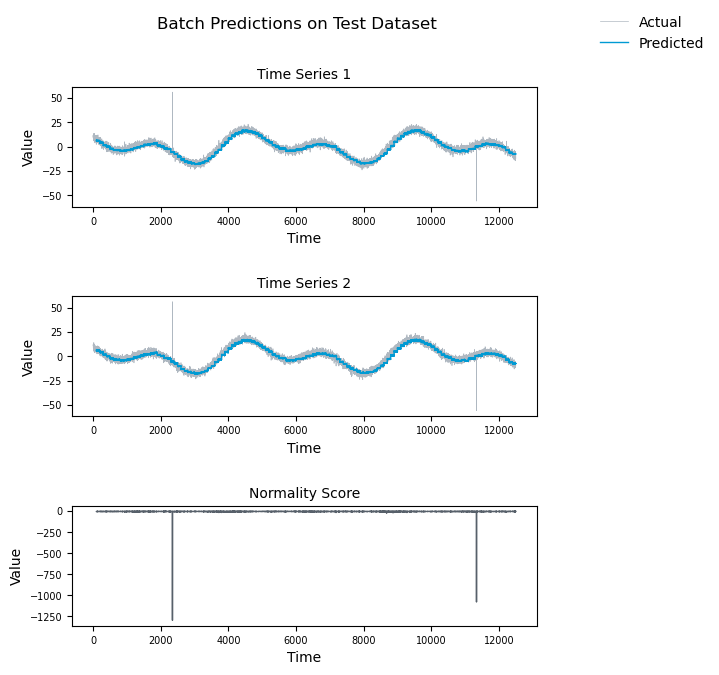

In [57]:
fig, axs = plt.subplots(nrows=test_dataset.shape[1] + 1, ncols=1, sharex=True, figsize=(6, 7))
for i in range(test_dataset.shape[1]):
    axs[i].plot(test_dataset.iloc[:, i], color="#AFB8C1", lw=0.5, label="Actual" if i == 0 else None)
    axs[i].plot(batch_predictions.iloc[:, i + 1], color="#009ad3", lw=1, label="Predicted" if i == 0 else None)
    axs[i].set_title(f"Time Series {i + 1}", size=10)
    axs[i].set(xlabel="Time", ylabel="Value")
    axs[i].xaxis.set_tick_params(labelbottom=True)
    axs[i].tick_params(axis="both", which="major", labelsize=7)
    axs[i].tick_params(axis="both", which="minor", labelsize=7)
i += 1
axs[i].set_title("Normality Score", size=10)
axs[i].plot(batch_predictions.iloc[:, 0], color="#57606a", lw=1)
axs[i].set(xlabel="Time", ylabel="Value")
axs[i].xaxis.set_tick_params(labelbottom=True)
axs[i].tick_params(axis="both", which="major", labelsize=7)
axs[i].tick_params(axis="both", which="minor", labelsize=7)
fig.subplots_adjust(hspace=0.75)
fig.suptitle("Batch Predictions on Test Dataset")
fig.legend(bbox_to_anchor=(1.2, 1, 0, 0), frameon=False)
fig.show()

In [58]:
batch_results = sagemaker_session.upload_string_as_file_body(
    body=batch_predictions.to_csv(index=False, header=False),
    bucket=bucket,
    key="data/inference/output/batch/batch_predictions.csv"
)

In [59]:
batch_results

's3://sagemaker-eu-west-1-661670223746/data/inference/output/batch/batch_predictions.csv'

## 7. Clean-up

### A. Delete the model

In [60]:
transformer.delete_model()

INFO:sagemaker:Deleting model with name: lstm-ad-algo-v1-6-2023-09-09-19-21-44-4-2023-09-09-19-22-29-908


### B. Unsubscribe to the listing (optional)

If you would like to unsubscribe to the algorithm, follow these steps. Before you cancel the subscription, ensure that you do not have any [deployable model](https://console.aws.amazon.com/sagemaker/home#/models) created from the model package or using the algorithm. Note - You can find this information by looking at the container name associated with the model. 

**Steps to unsubscribe to product from AWS Marketplace**:
1. Navigate to __Machine Learning__ tab on [__Your Software subscriptions page__](https://aws.amazon.com/marketplace/ai/library?productType=ml&ref_=mlmp_gitdemo_indust)
2. Locate the listing that you want to cancel the subscription for, and then choose __Cancel Subscription__  to cancel the subscription.

